In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from linearmodels.panel import PooledOLS, PanelOLS, FirstDifferenceOLS

# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [ ]:
# What do the columns mean:

# rgnp: Real GNP.
# pgnp: Potential real GNP.
# ulc: Unit labor cost.
# gdfco: Fixed weight deflator for personal consumption expenditure excluding food andenergy.
# gdf: Fixed weight GNP deflator.
# gdfim: Fixed weight import deflator.
# gdfcf: Fixed weight deflator for food in personal consumption expenditure.
# gdfce: Fixed weight deflator for energy in personal consumption expenditure.

In [ ]:
# 1. Test which series Granger cause each other.

In [18]:
df = pd.read_csv('data/raotb16.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
data = np.log(df).diff().dropna()

# or
df_log = np.log(df)
df_smooth = df_log.rolling(window = 4).mean()
sub_df = df_log - df_smooth
sub_df.dropna(inplace = True)

In [19]:
data

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-04-01,0.018870,0.008606,0.000000,0.013459,0.002670,0.003711,-0.003101,0.012903
1959-07-01,-0.004592,0.008593,0.024949,0.005333,0.002663,0.003697,0.006192,0.000000
1959-10-01,0.008494,0.008581,0.002051,0.002656,0.005305,0.000000,0.003082,0.016950
1960-01-01,0.017014,0.008628,0.006129,0.002649,0.000000,0.003683,-0.003082,0.000000
1960-04-01,-0.002876,0.008614,0.010132,0.005277,0.005277,0.007326,0.012270,0.004193
...,...,...,...,...,...,...,...,...
1988-07-01,0.007947,0.006010,0.005024,0.009167,0.012893,0.000942,0.020451,0.005402
1988-10-01,0.006583,0.005999,0.009421,0.013595,0.010355,0.010305,0.011272,0.001077
1989-01-01,0.009149,0.006013,0.015326,0.011190,0.011816,0.020296,0.013519,0.011771


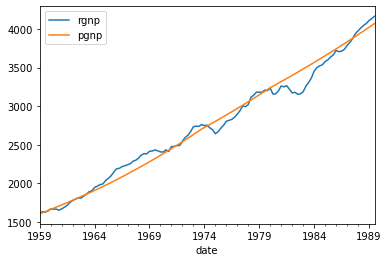

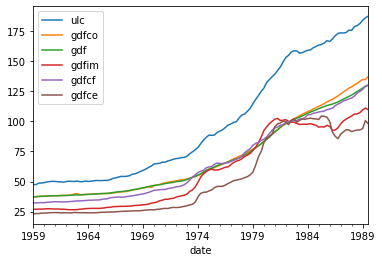

In [29]:
# separating these next two plots because big difference in y-axis 

df.plot(y=['rgnp', 'pgnp'])
df.plot(y=['ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'])
plt.show()

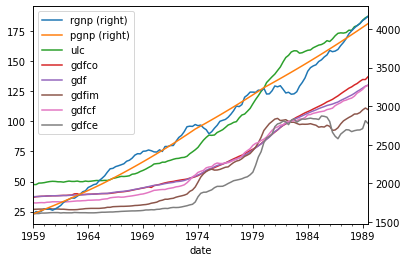

In [26]:
# or can actually put the plots together like this:
df.plot(secondary_y=['rgnp', 'pgnp']);

In [49]:
# Testing Granger Causality on the log-ed and differenced data

model = VAR(sub_df)
results = model.fit(maxlags= 12, ic='aic')

col_list = [
    'rgnp', 
    'pgnp', 
    'ulc', 
    'gdfco', 
    'gdf', 
    'gdfim', 
    'gdfcf', 
    'gdfce'
            ]

for col in col_list:
        copy_col = col_list.copy()
        copy_col.remove(col)
        print(col, ' & ', copy_col)
        print(results.test_causality(col, copy_col, kind='f').summary())
        print('\n')

rgnp  &  ['pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'] do not Granger-cause rgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.312          1.428   0.105 (84, 88)
----------------------------------------------


pgnp  &  ['rgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['rgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'] do not Granger-cause pgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.239          1.428   0.161 (84, 88)
----------------------------------------------


ulc  &  ['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdf

In [ ]:
# ^^ Seems like 
# ['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'] do Granger-cause ulc
# ['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdfim', 'gdfcf', 'gdfce'] do  Granger-cause gdf
# ['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf'] do  Granger-cause gdfce

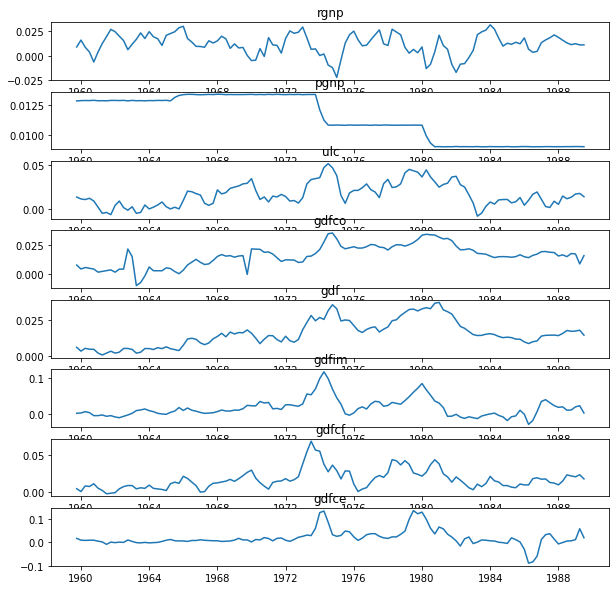

In [50]:
results.plot();

In [ ]:
# 2. Test which series are stationary

In [48]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color="blue",label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

 For column: rgnp


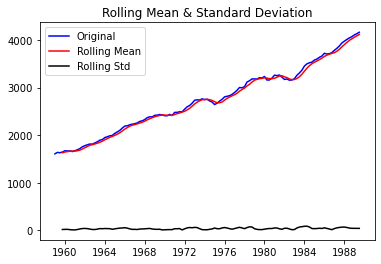

Results of Dickey-Fuller Test:
Test Statistic                   0.641882
p-value                          0.988604
#Lags Used                       2.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
None

 For column: pgnp


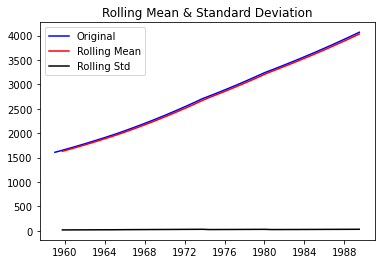

Results of Dickey-Fuller Test:
Test Statistic                   1.274320
p-value                          0.996461
#Lags Used                       1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
None

 For column: ulc


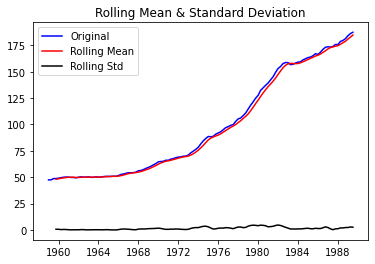

Results of Dickey-Fuller Test:
Test Statistic                   1.396716
p-value                          0.997099
#Lags Used                       2.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
None

 For column: gdfco


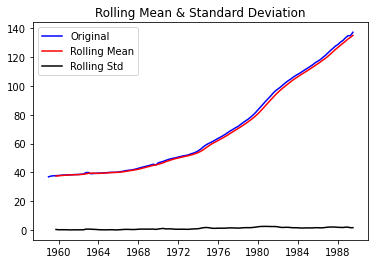

Results of Dickey-Fuller Test:
Test Statistic                   0.576191
p-value                          0.987014
#Lags Used                       5.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64
None

 For column: gdf


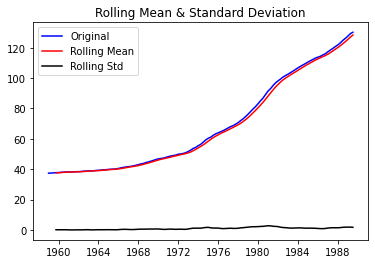

Results of Dickey-Fuller Test:
Test Statistic                   1.112860
p-value                          0.995325
#Lags Used                       7.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
None

 For column: gdfim


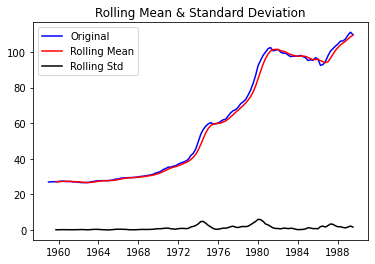

Results of Dickey-Fuller Test:
Test Statistic                  -0.198720
p-value                          0.938674
#Lags Used                       1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
None

 For column: gdfcf


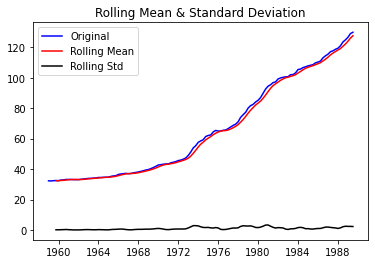

Results of Dickey-Fuller Test:
Test Statistic                   1.669255
p-value                          0.998051
#Lags Used                       9.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64
None

 For column: gdfce


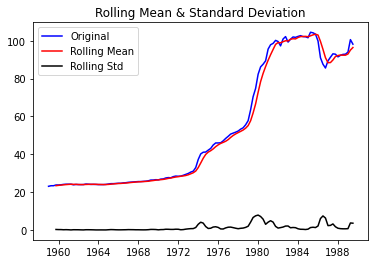

Results of Dickey-Fuller Test:
Test Statistic                  -0.815918
p-value                          0.814402
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
None



In [56]:
# First on raw data: nothing is stationary
for column in df.columns:
    print(f' For column: {column}')
    print(test_stationarity(df[column]))
    print("================================================\n")

In [52]:
# on log-ed and differenced data:
for col in sub_df.columns:
    p_val = adfuller(sub_df[col], autolag='AIC')[1]
    sta = 'stationary' if p_val < 0.05 else 'not stationnary' 
    print(f'{col} is {sta} (p-value = {p_val:.3f})\n')

rgnp is stationary (p-value = 0.001)

pgnp is not stationnary (p-value = 0.880)

ulc is stationary (p-value = 0.014)

gdfco is not stationnary (p-value = 0.329)

gdf is not stationnary (p-value = 0.451)

gdfim is stationary (p-value = 0.004)

gdfcf is not stationnary (p-value = 0.083)

gdfce is not stationnary (p-value = 0.089)



In [ ]:
# 3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

In [53]:
non_stnry = ['pgnp', 'gdfco', 'gdf', 'gdfcf', 'gdfce'] # non-stationary columns
stnry = df.columns.drop(non_stnry) # stationary
data = df.copy() # copy dataframe
data[non_stnry] = np.log(data[non_stnry]).diff()
data[stnry] = np.log(data[stnry])
data = data.dropna()
data

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-04-01,7.400621,0.008606,3.860730,0.013459,0.002670,3.295837,-0.003101,0.012903
1959-07-01,7.396028,0.008593,3.885679,0.005333,0.002663,3.299534,0.006192,0.000000
1959-10-01,7.404523,0.008581,3.887730,0.002656,0.005305,3.299534,0.003082,0.016950
1960-01-01,7.421537,0.008628,3.893859,0.002649,0.000000,3.303217,-0.003082,0.000000
1960-04-01,7.418661,0.008614,3.903991,0.005277,0.005277,3.310543,0.012270,0.004193
...,...,...,...,...,...,...,...,...
1988-07-01,8.304668,0.006010,5.190732,0.009167,0.012893,4.665324,0.020451,0.005402
1988-10-01,8.311251,0.005999,5.200153,0.013595,0.010355,4.675629,0.011272,0.001077
1989-01-01,8.320399,0.006013,5.215479,0.011190,0.011816,4.695925,0.013519,0.011771


In [55]:
model = VAR(data) 
model.select_order(12)
results = model.fit(maxlags=12, ic='aic') # fit model
results.summary() # show results

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


0.056           0.955
L7.gdfco          0.495846         0.592722            0.837           0.403
L7.gdf            0.606366         1.732405            0.350           0.726
L7.gdfim          0.367497         0.507284            0.724           0.469
L7.gdfcf          0.787251         0.560877            1.404           0.160
L7.gdfce         -0.058161         0.303985           -0.191           0.848
L8.rgnp          -0.016417         0.764959           -0.021           0.983
L8.pgnp          -4.372214        22.140102           -0.197           0.843
L8.ulc           -0.190787         0.859573           -0.222           0.824
L8.gdfco         -0.137265         0.583291           -0.235           0.814
L8.gdf            1.041040         1.658405            0.628           0.530
L8.gdfim         -0.230194         0.545563           -0.422           0.673
L8.gdfcf          0.189289         0.538663            0.351           0.725
L8.gdfce         -0.004903         0.279852           

In [ ]:
# 4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


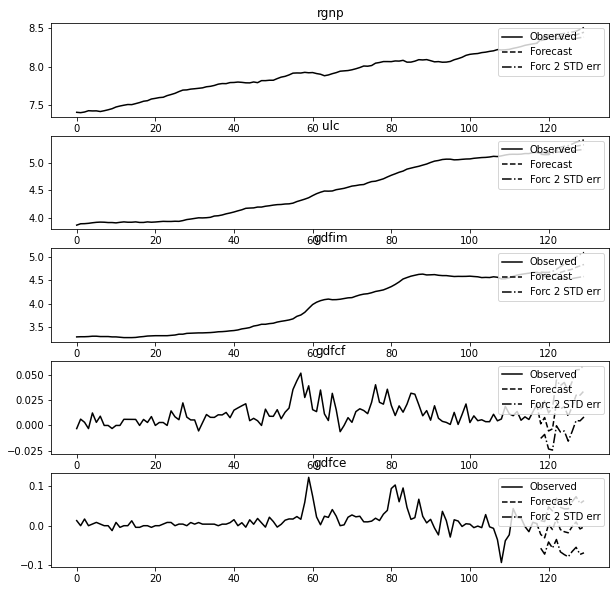

In [56]:
train = data[:-4] #remove past 4 quarters
model = VAR(train[['rgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce']]) #training on stationary data
results = model.fit(maxlags=12, ic='aic')
#results.forecast(data.values[-lag_order:], 5)
results.plot_forecast(12);

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [ ]:
# group by month state or month city
# date is not based on month, but daily so convert to floor_date in python and ocnvert to month
# group by month/state
# can look at # killed or injured and use timesiries
# for all of US only group by month/date

# Rony didnt find anything. Can say all data columns arent very helpful for us 

In [10]:
# !pip install linearmodels

In [156]:
from linearmodels.datasets import wage_panel
import pandas as pd

df_guns = pd.read_csv('data/gun-violence.csv')
df_guns = df_guns[['date','city_or_county', 'n_killed', 'n_injured', 'n_guns_involved']]
df_guns['date'] = pd.to_datetime(df_guns.date)
df_guns['month'] = df_guns['date'].dt.strftime('%Y-%m-01')
df_guns['month'] = pd.to_datetime(df_guns.month)

# grab only desired cities
situ = df_guns.loc[(df_guns.city_or_county=='Chicago') |
                      (df_guns.city_or_county=='Washington') |
                      (df_guns.city_or_county=='New Orleans')]

# set indices
situ = situ.set_index(['city_or_county', 'month'])
situ['month'] = situ['date'].dt.strftime('%Y-%m-01')
situ

# df_guns = df_guns.set_index(['city_or_county', 'month'])
# df_guns['month'] = df_guns['date'].dt.strftime('%Y-%m-01')
# df_guns

date  n_killed  n_injured  n_guns_involved  \
city_or_county month                                                         
New Orleans    2013-01-01 2013-01-21         0          5              NaN   
Washington     2013-01-01 2013-01-26         0          5              1.0   
Chicago        2013-02-01 2013-02-07         0          4              NaN   
New Orleans    2013-02-01 2013-02-09         0          4              1.0   
Washington     2013-03-01 2013-03-11         0         13              4.0   
...                              ...       ...        ...              ...   
Chicago        2018-03-01 2018-03-31         0          1              1.0   
Washington     2018-03-01 2018-03-31         0          0              1.0   
               2018-03-01 2018-03-31         1          0              1.0   
               2018-03-01 2018-03-31         0          0              1.0   
Chicago        2018-03-01 2018-03-31         0          1              1.0   

                                month  
city_or_county month                   
New Orleans    2013-01-01  2013-01-01  
Washington     2013-01-01  2013-01-01  
Chicago        2013-02-01  2013-02-01  
New Orleans    2013-02-01  2013-02-01  
Washington     2013-03-01  2013-03-01  
...                               ...  
Chicago        2018-03-01  2018-03-01  
Washington     2018-03-01  2018-03-01  
               2018-03-01  2018-03-01  
               2018-03-01  2018-03-01  
Chicago        2018-03-01  2018-03-01  

[17164 rows x 5 columns]

In [157]:
# Want a sum of total affected (killed + injured)
df_guns['total_affected'] = df_guns.n_killed + df_guns.n_injured 
df_guns

,date,city_or_county,n_killed,n_injured,n_guns_involved,month,total_affected
0,2013-01-01,Mckeesport,0,4,NaN,2013-01-01,4
1,2013-01-01,Hawthorne,1,3,NaN,2013-01-01,4
2,2013-01-01,Lorain,1,3,2.0,2013-01-01,4
3,2013-01-05,Aurora,4,0,NaN,2013-01-01,4
4,2013-01-07,Greensboro,2,2,2.0,2013-01-01,4
...,...,...,...,...,...,...,...
239672,2018-03-31,Rayne,0,0,1.0,2018-03-01,0
239673,2018-03-31,Natchitoches,1,0,1.0,2018-03-01,1
239674,2018-03-31,Gretna,0,1,1.0,2018-03-01,1
239675,2018-03-31,Houston,1,0,1.0,2018-03-01,1


In [164]:
# Looking at Chicago

chicago = (
    df_guns.loc[df_guns.city_or_county=='Chicago']
           .groupby(pd.Grouper(key="date", freq='MS'))
           .sum()
                 )
chicago = chicago[['total_affected']]
chicago.head()

,total_affected
date,
2013-02-01,4
2013-03-01,7
2013-04-01,0
2013-05-01,8
2013-06-01,24


In [165]:
adfuller_test(chicago.total_affected)

P=0.1641. Non-Stationary.


In [166]:
# 1st difference
chicago_diff = chicago.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
adfuller_test(chicago_diff.total_affected)

P=0.0. Stationary.


In [167]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = chicago_diff
model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=671.962, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=671.118, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=669.969, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=670.335, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=671.952, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=673.816, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=671.779, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.206 seconds


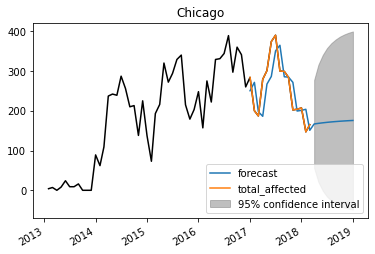

In [170]:
model = ARIMA(chicago, order=(1, 0, 0))  
res = model.fit(disp=-1)
  
fig, ax = plt.subplots()
ax.plot(chicago[:],color='black')

res.plot_predict('2017-01-01','2019-01-01',ax=ax)
plt.title(label='Chicago');

In [171]:
# Looking at Washington

wash = (
    df_guns.loc[df_guns.city_or_county=='Washington']
           .groupby(pd.Grouper(key="date", freq='MS'))
           .sum()
                 )
wash = wash[['total_affected']]
wash.head()

,total_affected
date,
2013-01-01,5
2013-02-01,0
2013-03-01,13
2013-04-01,0
2013-05-01,0


In [173]:
adfuller_test(wash.total_affected)

P=0.0096. Stationary.


In [172]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = wash
model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=448.424, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=456.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=450.067, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=451.600, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=454.477, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=450.424, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=450.424, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=452.997, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=451.094, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=451.469, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=446.728, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=449.950, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=448.403, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=448.727, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=448.7

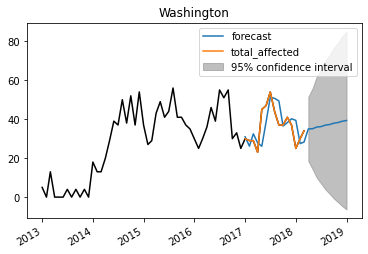

In [174]:
model = ARIMA(wash, order=(1,1,1))  
res = model.fit(disp=-1)
  
fig, ax = plt.subplots()
ax.plot(wash[:],color='black')

res.plot_predict('2017-01-01','2019-01-01',ax=ax)
plt.title(label='Washington');

In [175]:
# Looking at New Orleans

n_orl = (
    df_guns.loc[df_guns.city_or_county=='New Orleans']
           .groupby(pd.Grouper(key="date", freq='MS'))
           .sum()
                 )
n_orl = n_orl[['total_affected']]
n_orl.head()

,total_affected
date,
2013-01-01,5
2013-02-01,4
2013-03-01,0
2013-04-01,0
2013-05-01,19


In [176]:
adfuller_test(n_orl)

P=0.0583. Non-Stationary.


In [178]:
# 1st difference
n_orl_diff = n_orl.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
adfuller_test(n_orl_diff.total_affected)

P=0.0. Stationary.


In [179]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = n_orl_diff
model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=503.730, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=505.937, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=503.986, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=502.428, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=503.792, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=505.720, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=504.224, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.192 seconds


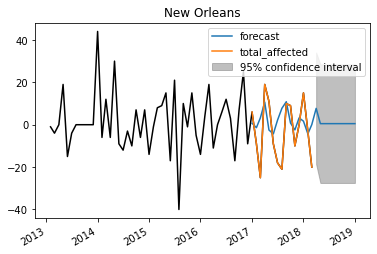

In [183]:
model = ARIMA(n_orl_diff, order=(0,0,1))  
res = model.fit(disp=-1)
  
fig, ax = plt.subplots()
ax.plot(n_orl_diff[:],color='black')

res.plot_predict('2017-01-01','2019-01-01',ax=ax,)
plt.title(label='New Orleans');

In [158]:
# Looking at USA

df_usa = df_guns.groupby(['month']).sum()
df_usa = df_usa[['total_affected']]
df_usa.head()

,total_affected
month,
2013-01-01,67
2013-02-01,59
2013-03-01,100
2013-04-01,78
2013-05-01,121


In [159]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = df_usa
model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=949.513, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=953.123, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=947.577, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=948.822, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=951.732, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=949.529, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=951.465, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=946.727, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=948.569, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=948.585, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=948.203, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=950.202, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.594 seconds


In [160]:
from statsmodels.tsa.stattools import adfuller


def adfuller_test(series, signif=0.05, name='', verbose=False):
    """
    Perform ADFuller to test for Stationarity of given series 
    and print report
    """
    r = adfuller(series, autolag='AIC')
    output = {
        'test_statistic':round(r[0], 4), 
        'pvalue':round(r[1], 4), 
        'n_lags':round(r[2], 4), 
        'n_obs':r[3]
              }
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    if p_value <= signif:
        print(f"P={p_value}. Stationary.")
    else:
        print(f"P={p_value}. Non-Stationary.")

adfuller_test(df_usa.total_affected)

P=0.0. Stationary.


/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


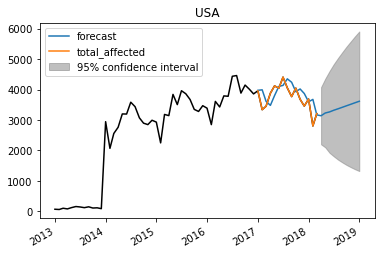

In [161]:
model = ARIMA(df_usa, order=(1, 1, 0))  
res = model.fit(disp=-1)
  
fig, ax = plt.subplots()
ax.plot(df_usa[:],color='black')

res.plot_predict('2017-01-01', '2019-01-01',ax=ax)
plt.title(label='USA');

In [77]:
# 2. Are there other (non time series) predictors which could be used in this dataset to help 
# predict severity or number of shootings in the future? Analyze the data for feature importance 
# and explain your findings.

In [ ]:
# Could possibly look at location (latitude and longitude) and see if there are any insights there. 
# To predict the severity, would be great to have other info as well such as police response time.
# If possible we could also look at gender and age of the shooter, as well as type of weapon used
# (e.g. automatic, caliber type, etc.)